# Extract Feature from Each Frame

In [24]:
# Import libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [25]:
feature_scaler = StandardScaler()

# extract features from the CSV file
def extract_frame_features(frame_df, scaler=None):
    num_objects = len(frame_df)
    avg_conf = frame_df["confidence"].mean()
    avg_box_area = ((frame_df["x_max"] - frame_df["x_min"]) *
                    (frame_df["y_max"] - frame_df["y_min"])).mean()

    desired_size = 13
    class_counts = np.zeros(desired_size)

    for cls in frame_df["object_class"]:
        cls = int(cls)
        if cls < desired_size:
            class_counts[cls] += 1

    raw_features = [num_objects, avg_conf, avg_box_area] + class_counts.tolist()
    
    if scaler:
        raw_features = scaler.transform([raw_features])[0]  # normalize
    return torch.tensor(raw_features, dtype=torch.float32)


# Process the CSV file and extract features for each frame
def process_video_csv(csv_path, scaler = None):
    df = pd.read_csv(csv_path)

    sequences = []
    if "frame" not in df.columns or df.empty:
        return torch.empty(0, 16)  # return empty tensor with correct shape

    for _, frame_df in df.groupby("frame"):
        frame_feat = extract_frame_features(frame_df, scaler = scaler)
        sequences.append(frame_feat)

    if not sequences:
        return torch.empty(0, 16)  
    return torch.stack(sequences)




# Load Data Labels

In [26]:
import csv

# Load label CSV into a dictionary
label_dict = {}
with open("../../data/train_labels.csv", newline = "") as f:
    reader = csv.DictReader(f)
    for row in reader:
        label_dict[row["id"]] = int(row["target"])

# Gather all video directories
video_dirs = sorted([
    os.path.join("../../data/yolo_processed_data", d)
    for d in os.listdir("../../data/yolo_processed_data")
    if os.path.isdir(os.path.join("../../data/yolo_processed_data", d))
])

# Split Data into Training, Validation, and Test Sets

In [27]:
# Filter out videos with >75% empty frames
def filter_videos_by_frame_coverage(video_dirs, empty_threshold=0.75):
    filtered = []
    for video_dir in video_dirs:
        csv_path = os.path.join(video_dir, "detections.csv")
        df = pd.read_csv(csv_path)
        # Count total frames via image files
        jpgs = [f for f in os.listdir(video_dir) if f.lower().endswith(".jpg")]
        total_frames = len(jpgs)
        detected_frames = df["frame"].nunique()
        empty_ratio = (total_frames - detected_frames) / total_frames if total_frames > 0 else 1.0
        if empty_ratio <= empty_threshold:
            filtered.append(video_dir)
    return filtered

video_dirs = filter_videos_by_frame_coverage(video_dirs, empty_threshold=0.75)

# Split video IDs
video_ids = [os.path.basename(v).replace("video_", "") for v in video_dirs]
from sklearn.model_selection import train_test_split
train_ids, temp_ids = train_test_split(video_ids, test_size=0.2, random_state=42)
val_ids, test_ids = train_test_split(temp_ids, test_size=0.5, random_state=42)

def get_dirs(ids):
    return [os.path.join("../../data/yolo_processed_data", "video_" + vid) for vid in ids]

train_videos = get_dirs(train_ids)
val_videos   = get_dirs(val_ids)
test_videos  = get_dirs(test_ids)

# Feature scaler
feature_scaler = StandardScaler()
all_train_feats = []
for video_dir in train_videos:
    df = pd.read_csv(os.path.join(video_dir, "detections.csv"))
    for _, frame_df in df.groupby("frame"):
        # extract raw features (no scaler)
        num_objects = len(frame_df)
        avg_conf = frame_df["confidence"].mean()
        avg_box_area = ((frame_df["x_max"]-frame_df["x_min"])*(frame_df["y_max"]-frame_df["y_min"])).mean()
        counts = np.zeros(13)
        for cls in frame_df["object_class"]:
            c = int(cls)
            if c < 13: counts[c] +=1
        feat = [num_objects, avg_conf, avg_box_area] + counts.tolist()
        all_train_feats.append(feat)
feature_scaler.fit(all_train_feats)

StandardScaler()

# Create Dataset and DataLoader

In [28]:
# Video Dataset class
class VideoDataset(Dataset):
    def __init__(self, video_dirs, label_dict, scaler=None):
        self.video_dirs = video_dirs
        self.label_dict = label_dict
        self.scaler = scaler
    def __len__(self): return len(self.video_dirs)
    def __getitem__(self, idx):
        video_dir = self.video_dirs[idx]
        vid = os.path.basename(video_dir).replace("video_", "").zfill(5)
        label = self.label_dict.get(vid, 0)
        df = pd.read_csv(os.path.join(video_dir, "detections.csv"))
        seq = []
        for _, frame_df in df.groupby("frame"):
            # raw features
            num_objects = len(frame_df)
            avg_conf = frame_df["confidence"].mean()
            avg_box_area = ((frame_df["x_max"]-frame_df["x_min"])*(frame_df["y_max"]-frame_df["y_min"])).mean()
            counts = np.zeros(13)
            for cls in frame_df["object_class"]:
                c = int(cls)
                if c < 13: counts[c] +=1
            feat = [num_objects, avg_conf, avg_box_area] + counts.tolist()
            if self.scaler:
                feat = self.scaler.transform([feat])[0]
            seq.append(torch.tensor(feat, dtype=torch.float32))
        if not seq:
            return torch.empty(0,16), torch.tensor(label, dtype=torch.float32)
        return torch.stack(seq), torch.tensor(label, dtype=torch.float32)

# Collate fn 

def collate_fn(batch):
    batch = [(x,y) for x,y in batch if x.size(0)>0]
    if not batch: return None
    batch.sort(key=lambda x: x[0].size(0), reverse=True)
    seqs, labels = zip(*batch)
    lengths = torch.tensor([s.size(0) for s in seqs])
    padded = pad_sequence(seqs, batch_first=True)
    return padded, lengths, torch.stack(labels)

# DataLoaders
train_loader = DataLoader(VideoDataset(train_videos, label_dict, feature_scaler), batch_size=4, shuffle=True, collate_fn=collate_fn)
val_loader   = DataLoader(VideoDataset(val_videos,   label_dict, feature_scaler), batch_size=4, shuffle=False, collate_fn=collate_fn)
test_loader  = DataLoader(VideoDataset(test_videos,  label_dict, feature_scaler), batch_size=4, shuffle=False, collate_fn=collate_fn)

# Define the GRU Model

In [29]:
# Define the GRU model for classification
class GRUClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, dropout, num_layers):
        super().__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers=num_layers, dropout=dropout, batch_first = True, bidirectional = True)
        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x, lengths):
        packed = nn.utils.rnn.pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, hn = self.gru(packed)  
        out = self.fc(hn[-1])     # Get last hidden state
        return self.sigmoid(out).squeeze()



# Training Model

In [30]:
def train_model(model, train_loader, val_loader, criterion, optimizer, patience, device, epochs, print_epochs=False):
    model.to(device)

    train_losses, val_losses = [], []
    best_val_loss = float("inf")
    patience_counter = 0

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5, verbose=False)

    for epoch in range(epochs):
        model.train()
        train_loss = 0

        for batch in train_loader:
            if batch is None:
                continue

            x_batch, lengths, y_batch = batch
            x_batch, lengths, y_batch = x_batch.to(device), lengths.to(device), y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(x_batch, lengths)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation
        model.eval()
        val_loss = 0
        all_preds, all_targets = [], []

        with torch.no_grad():
            for batch in val_loader:
                if batch is None:
                    continue

                x_batch, lengths, y_batch = batch
                x_batch, lengths, y_batch = x_batch.to(device), lengths.to(device), y_batch.to(device)

                outputs = model(x_batch, lengths)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()

                all_preds.extend(outputs.cpu().numpy())
                all_targets.extend(y_batch.cpu().numpy())

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        # Scheduler step
        scheduler.step(avg_val_loss)

        # Print info
        if print_epochs:
            print(f"Epoch {epoch + 1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

        # Save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            
        else:
            patience_counter += 1
            if patience_counter >= patience:
                if print_epochs:
                    print("Early stopping triggered")
                break

    return train_losses, val_losses


In [31]:
# Function to iterate through different combinations of hyperparameters for GRU
def tune_gru_hyperparameters(train_loader, val_loader, params, input_size, epochs=50, patience=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    best_val_loss = float("inf")
    best_params = None
    all_results = []

    best_train_losses = []
    best_val_losses = []

    for hidden_size in params["hidden_size"]:
        for dropout in params["dropout"]:
            for learning_rate in params["learning_rate"]:
                for num_layers in params["num_layers"]:
                    for weight_decay in params.get('weight_decay', [0.0]):
                        for optimizer_type in params.get("optimizer", ["adam"]):
                            print(f"Training with hidden_size={hidden_size}, dropout={dropout}, "
                                f"lr={learning_rate}, num_layers={num_layers}, optimizer={optimizer_type}")

                            model = GRUClassifier(input_dim=input_size,
                                                hidden_dim=hidden_size,
                                                num_layers=num_layers,
                                                dropout=dropout)

                            if optimizer_type.lower() == "adam":
                                optimizer = torch.optim.Adam(
                                    model.parameters(),
                                    lr=learning_rate,
                                    weight_decay=weight_decay
                                )
                            else:
                                optimizer = torch.optim.SGD(
                                    model.parameters(),
                                    lr=learning_rate,
                                    weight_decay=weight_decay
                                )

                            criterion = nn.BCELoss()

                            train_losses, val_losses = train_model(
                                model=model,
                                train_loader=train_loader,
                                val_loader=val_loader,
                                criterion=criterion,
                                optimizer=optimizer,
                                patience=patience,
                                device=device,
                                epochs=epochs,
                                print_epochs=True
                            )

                            final_val_loss = val_losses[-1]
                            all_results.append({
                                "hidden_size": hidden_size,
                                "dropout": dropout,
                                "learning_rate": learning_rate,
                                "num_layers": num_layers,
                                "optimizer": optimizer_type,
                                "final_val_loss": final_val_loss
                            })

                            # Save best model and losses
                            if final_val_loss < best_val_loss:
                                best_val_loss = final_val_loss
                                best_params = {
                                    "hidden_size": hidden_size,
                                    "dropout": dropout,
                                    "learning_rate": learning_rate,
                                    "num_layers": num_layers,
                                    "optimizer": optimizer_type
                                }
                                best_train_losses = train_losses
                                best_val_losses = val_losses

    return best_params, all_results, best_train_losses, best_val_losses


In [ ]:
params = {
    "hidden_size": [128],
    "num_layers": [2],
    "dropout": [0.0, 0.1, 0.2],
    "learning_rate": [0.001, 0.0001, 0.00001],
    "weight_decay": [0.001],
    "optimizer_type": ["adam"]  
}


input_size = 16  # 3 summary features + 10 class counts + 3 one-hot encodings 
epochs = 50
patience = 10

best_params, results, train_losses, val_losses = tune_gru_hyperparameters(
    train_loader=train_loader,
    val_loader=val_loader,
    params=params,
    input_size=input_size,
    epochs=50,
    patience=10
)

# Plot training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss", marker='o')
plt.plot(val_losses, label="Validation Loss", marker='x')
plt.title("Training vs Validation Loss per Epoch (Best Model)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Training with hidden_size=128, dropout=0.0, lr=0.001, num_layers=2, optimizer=adam


/opt/anaconda3/envs/MyNewEnv/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


/opt/anaconda3/envs/MyNewEnv/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1, Train Loss: 0.6890, Val Loss: 0.6789
Epoch 2, Train Loss: 0.6764, Val Loss: 0.6604
Epoch 3, Train Loss: 0.6577, Val Loss: 0.6509
Epoch 4, Train Loss: 0.6534, Val Loss: 0.6319
Epoch 5, Train Loss: 0.6458, Val Loss: 0.6247
Epoch 6, Train Loss: 0.6450, Val Loss: 0.6449
Epoch 7, Train Loss: 0.6336, Val Loss: 0.6810
Epoch 8, Train Loss: 0.6279, Val Loss: 0.6580
Epoch 9, Train Loss: 0.5879, Val Loss: 0.6660
Epoch 10, Train Loss: 0.5370, Val Loss: 0.6899
Epoch 11, Train Loss: 0.4811, Val Loss: 0.7455
Epoch 12, Train Loss: 0.4528, Val Loss: 0.7743
Epoch 13, Train Loss: 0.4019, Val Loss: 0.8110
Epoch 14, Train Loss: 0.3282, Val Loss: 0.8802
Epoch 15, Train Loss: 0.2797, Val Loss: 0.9395
Early stopping triggered
Final Results:
Training Loss: 0.2797, Validation Loss: 0.9395, Test Loss: 1.0242, Test Accuracy: 0.5586
Precision: 0.6000, Recall: 0.5696, F1-score: 0.5844


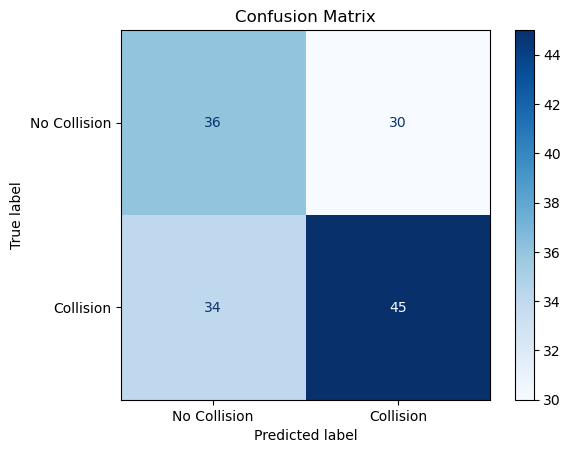

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.BCELoss()

# Initialize model with best params
best_model = GRUClassifier(
    input_dim=input_size,
    hidden_dim=best_params["hidden_size"],
    num_layers=best_params["num_layers"],
    dropout=best_params["dropout"]
).to(device)

# Retrain on train/val set using best hyperparameters
optimizer = torch.optim.Adam(
    best_model.parameters(),
    lr=best_params["learning_rate"],
    weight_decay=best_params.get("weight_decay", 0.0)  # defaults to 0 if missing
)


train_losses, val_losses = train_model(
    model=best_model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    patience=10,
    device=device,
    epochs=50,
    print_epochs=True
)

# Evaluate on test set
best_model.eval()
test_loss = 0
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        if batch is None:
            continue
        x_batch, lengths, y_batch = batch
        x_batch, lengths, y_batch = x_batch.to(device), lengths.to(device), y_batch.to(device)

        outputs = best_model(x_batch, lengths)
        if outputs.dim() == 0:
            outputs = outputs.unsqueeze(0)

        loss = criterion(outputs, y_batch)
        test_loss += loss.item()

        predicted = (outputs > 0.5).float()
        correct += (predicted == y_batch).sum().item()
        total += y_batch.size(0)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

# Metrics
test_loss /= len(test_loader)
test_accuracy = correct / total
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)

print('Final Results:')
print(f'Training Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}, '
      f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')
print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}')

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds, labels = [0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Collision", "Collision"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()
